In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt

import ray

from tools_ryu import mytool
from multi_run_v3.data_pp import DataPreprocess
from multi_run_v3.momentum import make_group_mask
from multi_run_v3.momentum_strategy import *
from multi_run_v2.initialize_v2 import make_market_index
#from multi_run_v3.backtest import simulate_longonly, simulate_longshort

2023-08-19 19:00:00,426	INFO worker.py:1625 -- Started a local Ray instance.


In [2]:
data = pd.read_pickle("Data/cmktcap_data_final.pickle")

days_lst = ["MON","TUE","WED","THU","FRI","SAT","SUN"]

In [3]:
data_pp = DataPreprocess()
data_pp.initialize(data=data)
data_pp.make_mask(mktcap_thresh=1_000_000,
                  vol_thresh=1_000_000,
                  ma=True)

In [4]:
mkt = make_market_index(data_pp.price_df,
                        data_pp.mktcap_df,
                        data_pp.vol_df,
                        1_000_000,
                        1_000_000,
                        True)

In [5]:
# Ray Data 생성
ray_price = ray.put(data_pp.price_df)
ray_mktcap = ray.put(data_pp.mktcap_df)
ray_vol = ray.put(data_pp.vol_df)
ray_daily_rtn = ray.put(data_pp.daily_rtn_df)
ray_weekly_rtn = ray.put(data_pp.weekly_rtn_df)
ray_mask = ray.put(data_pp.mask)

In [6]:
# Terra Luna 제거

#price_pp = cmkt_data["price"].drop("4172", axis=1)
#mktcap_pp = cmkt_data["mktcap"].drop("4172", axis=1)
#vol_pp = cmkt_data["vol"].drop("4172", axis=1)
#ray_price = ray.put(price_pp)
#ray_mktcap = ray.put(mktcap_pp)
#ray_vol = ray.put(vol_pp)

### Value Weighted, Marketcap Capped 

In [7]:
momentum_capped_cmkt = {}

momentum_capped_future = [weekly_momentum_value_weighted_capped.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       daily_rtn_df = ray_daily_rtn,
                                                                       weekly_rtn_df = ray_weekly_rtn,
                                                                       mask_df = ray_mask,
                                                                       fee_rate = 0.0015,
                                                                       n_group=5,
                                                                       day_of_week=day,
                                                                       num_cap=0.95, # 5% capped
                                                                       margin ='cross',
                                                                       leverage_ratio=2) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [8]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [9]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

In [10]:
font = {'family': 'serif', 'style': 'italic'}

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

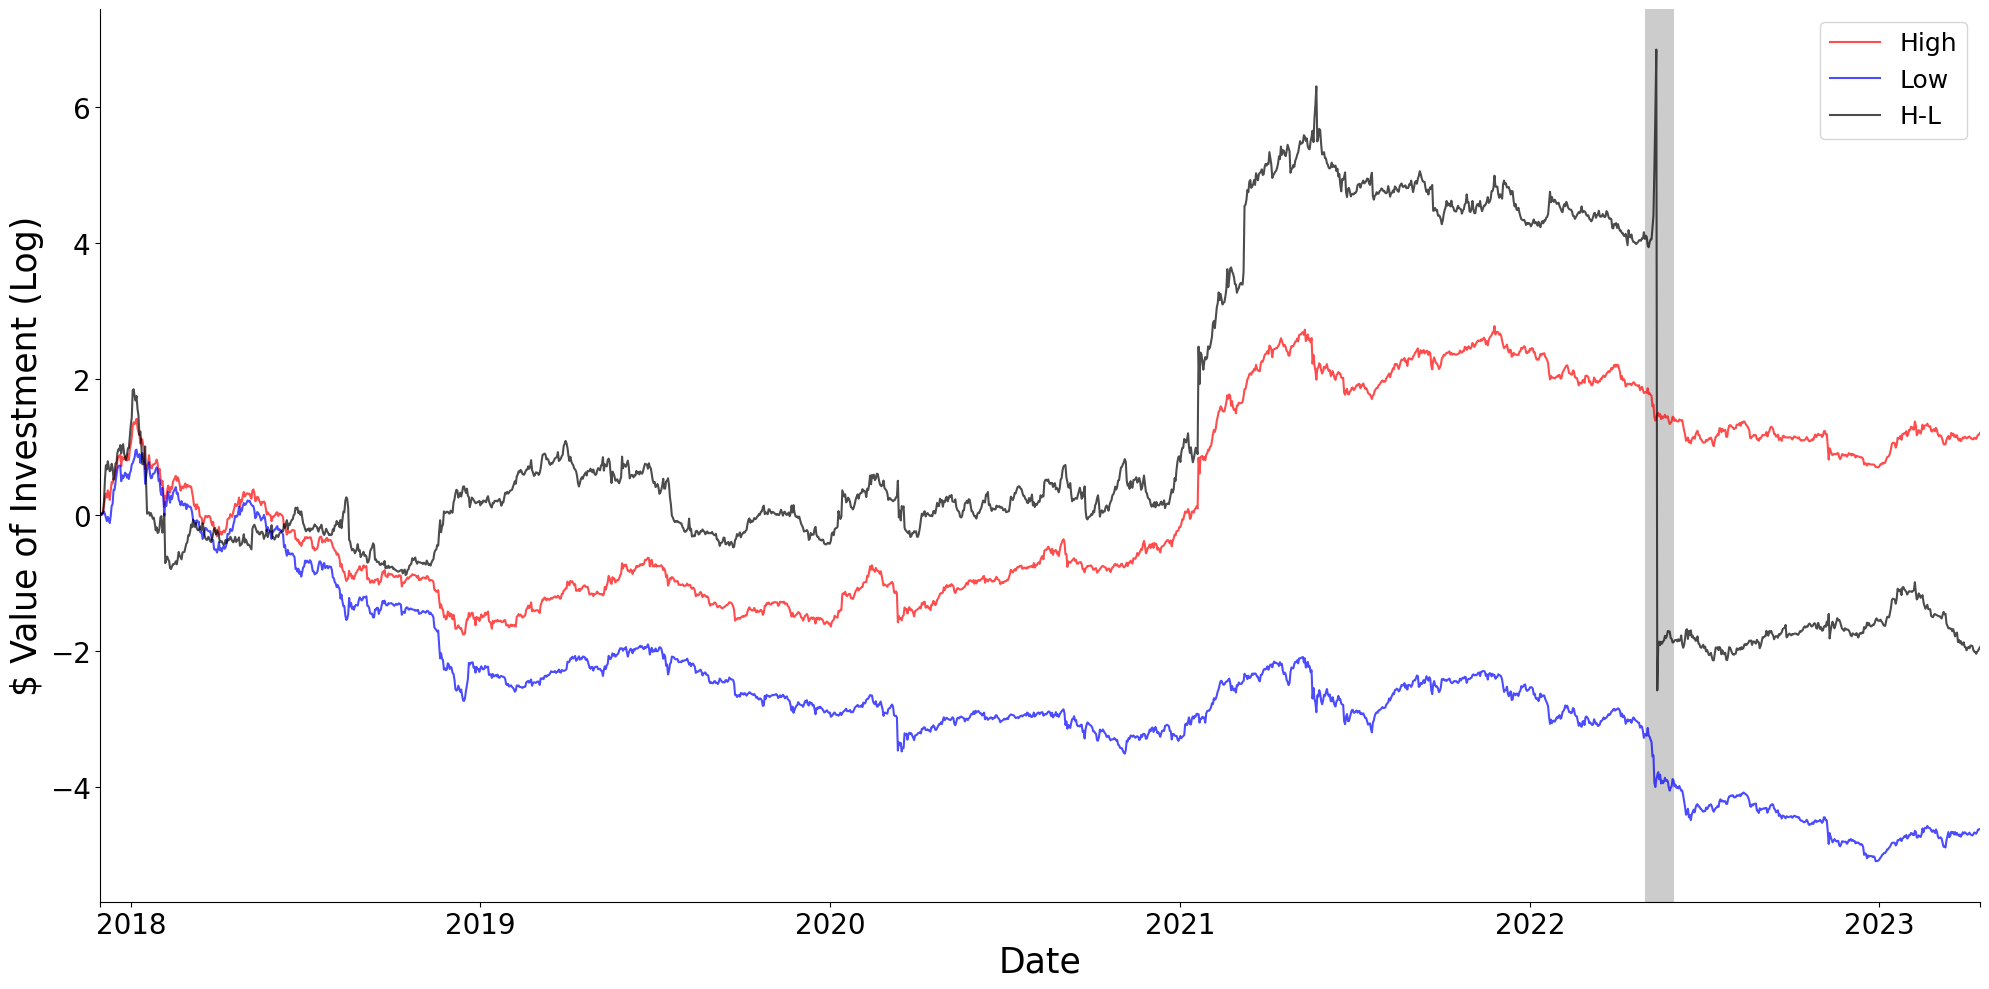

In [11]:
import matplotlib.dates as mdates

np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7, fontsize=20)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment (Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

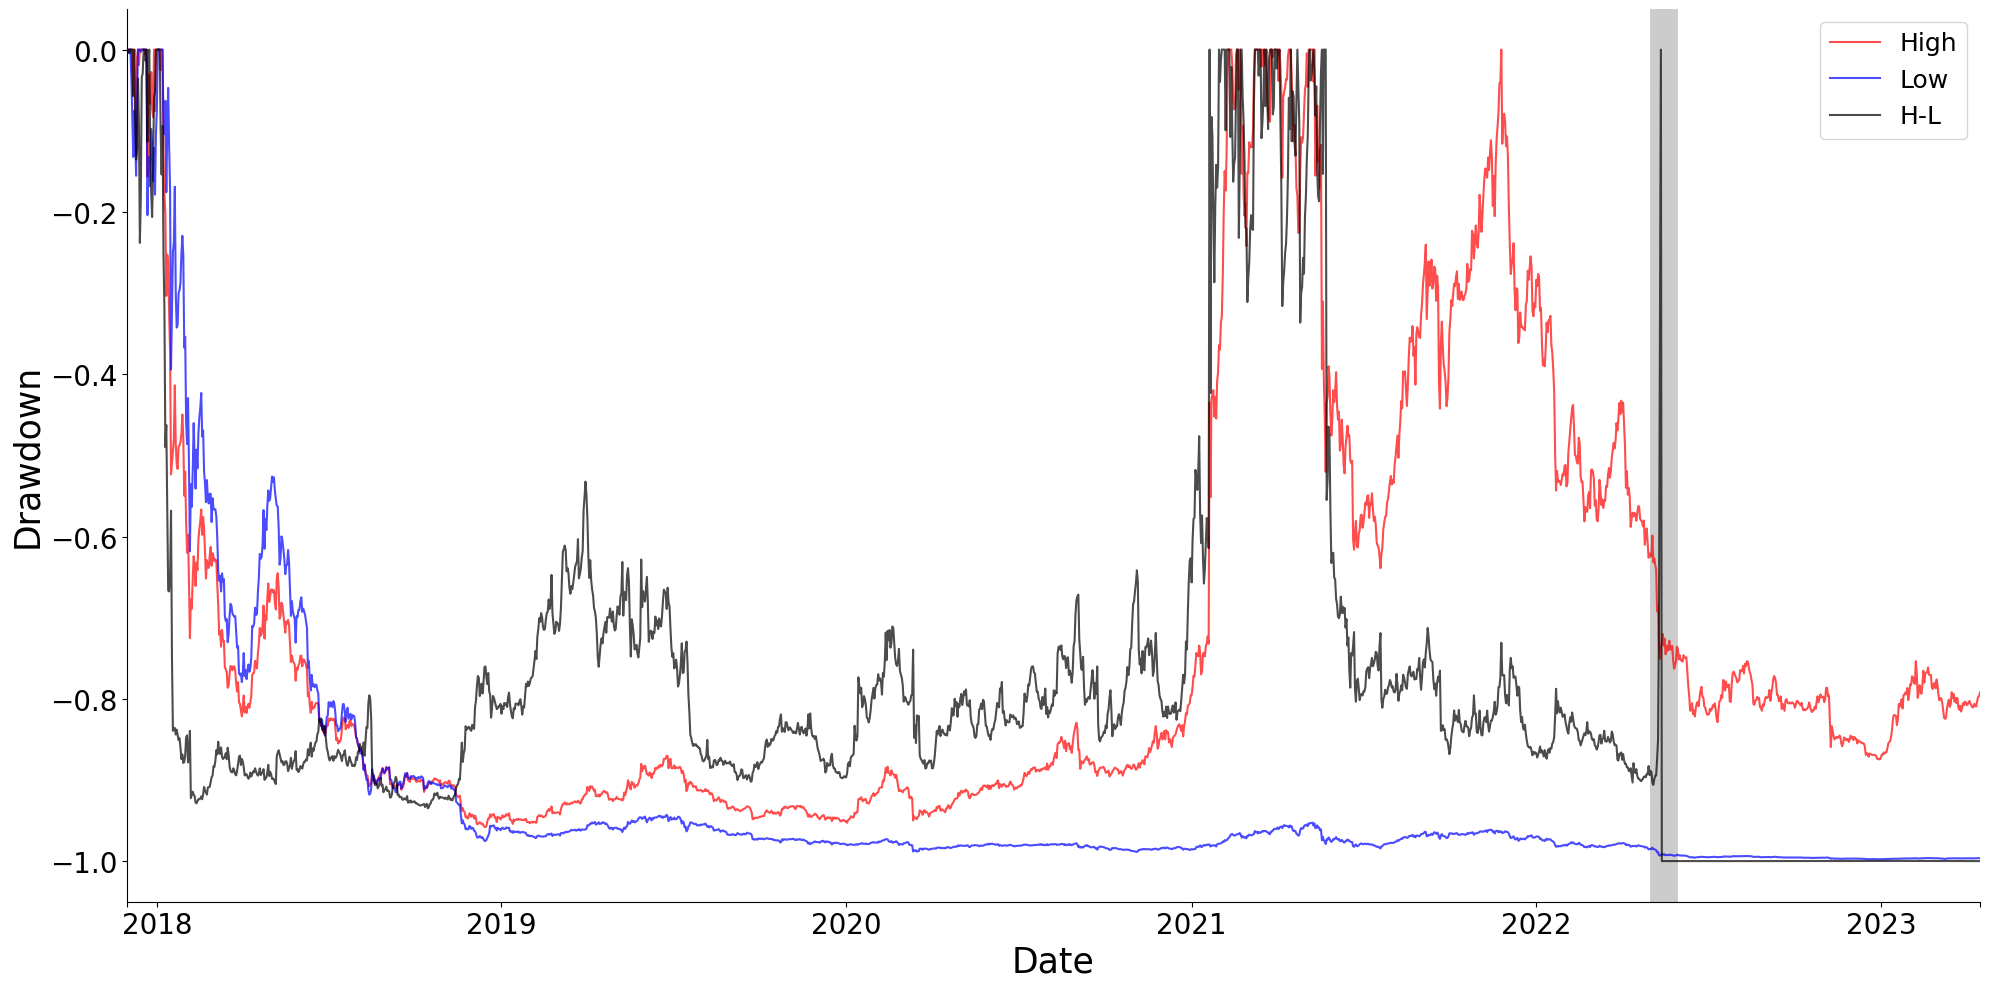

In [12]:
high = (fin_c["Long_Q5"] + 1).cumprod()
low = (fin_c["Long_Q1"] + 1).cumprod()
h_l = (fin_c["LS"] + 1).cumprod()

high_peak = high.cummax()
low_peak = low.cummax()
h_l_peak = h_l.cummax()

high_dd = (high - high_peak) / high_peak
low_dd = (low - low_peak) / low_peak
h_l_dd = (h_l - h_l_peak) / h_l_peak

pd.concat([high_dd, low_dd, h_l_dd], axis=1,
          keys=["High","Low","H-L"]).plot(figsize=(20,10), 
                                          color=["red","blue","black"],
                                          alpha=0.7,
                                          fontsize=20)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

plt.legend(["High", "Low","H-L"], fontsize=18)


start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [13]:
mytool.print_statistics(fin_c)

,Long_Q1,Long_Q2,Long_Q3,Long_Q4,Long_Q5,LS
Mean,-0.367170,0.146310,0.406520,0.522550,0.735860,3.142200
STD,0.975037,0.929916,0.898527,0.881375,1.047581,2.571917
CAGR,-0.576400,-0.258300,-0.010200,0.126000,0.248900,-0.303600
MDD,0.998000,0.975000,0.955000,0.942000,0.958000,1.000000
Sharpe,-0.376571,0.157337,0.452429,0.592880,0.702437,1.221735


Volume_weighted_capped

In [14]:
momentum_capped_cmkt = {}

momentum_capped_future = [weekly_momentum_volume_weighted_capped.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       vol_df = ray_vol,
                                                                       daily_rtn_df = ray_daily_rtn,
                                                                       weekly_rtn_df = ray_weekly_rtn,
                                                                       mask_df = ray_mask,
                                                                       fee_rate = 0.0015,
                                                                       n_group=5,
                                                                       day_of_week=day,
                                                                       num_cap=0.95, # 5%
                                                                       leverage_ratio=2
                                                                       ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [15]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [17]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

c:\Users\user\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


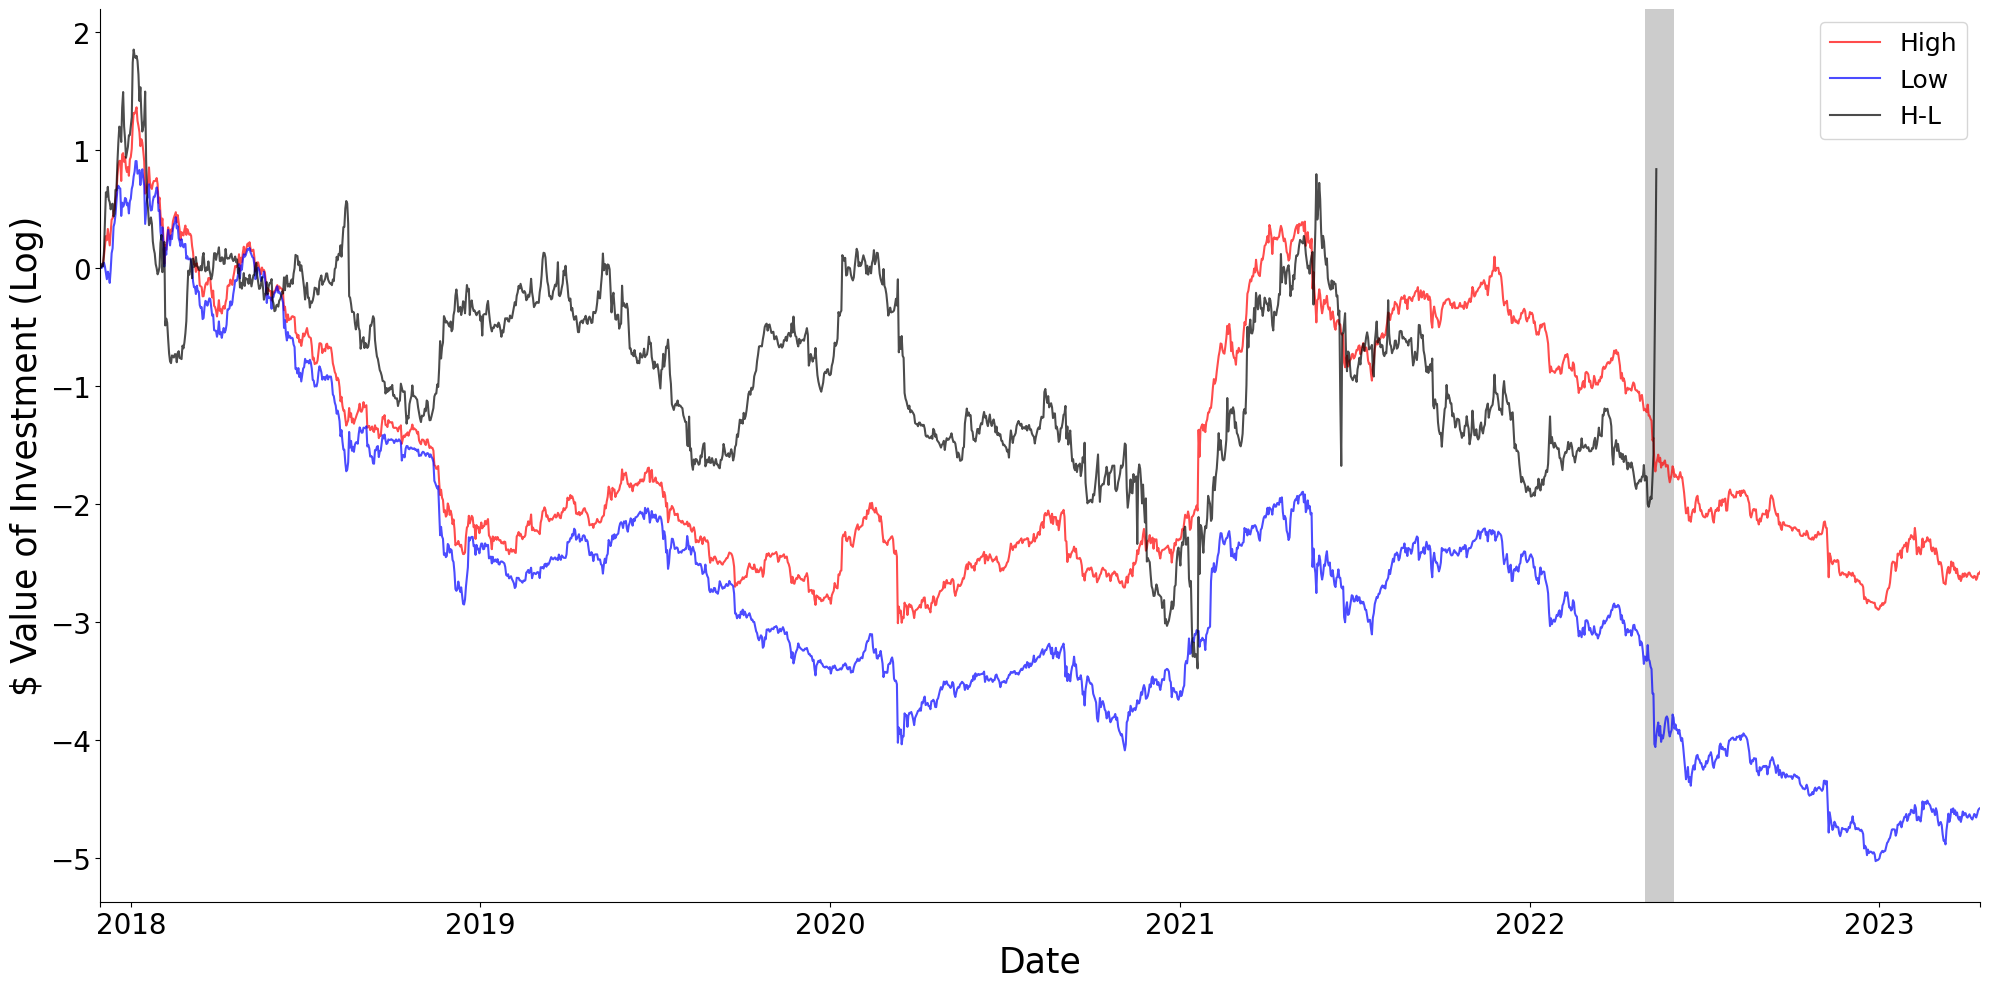

In [23]:
import matplotlib.dates as mdates

np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7, fontsize=20)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment (Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

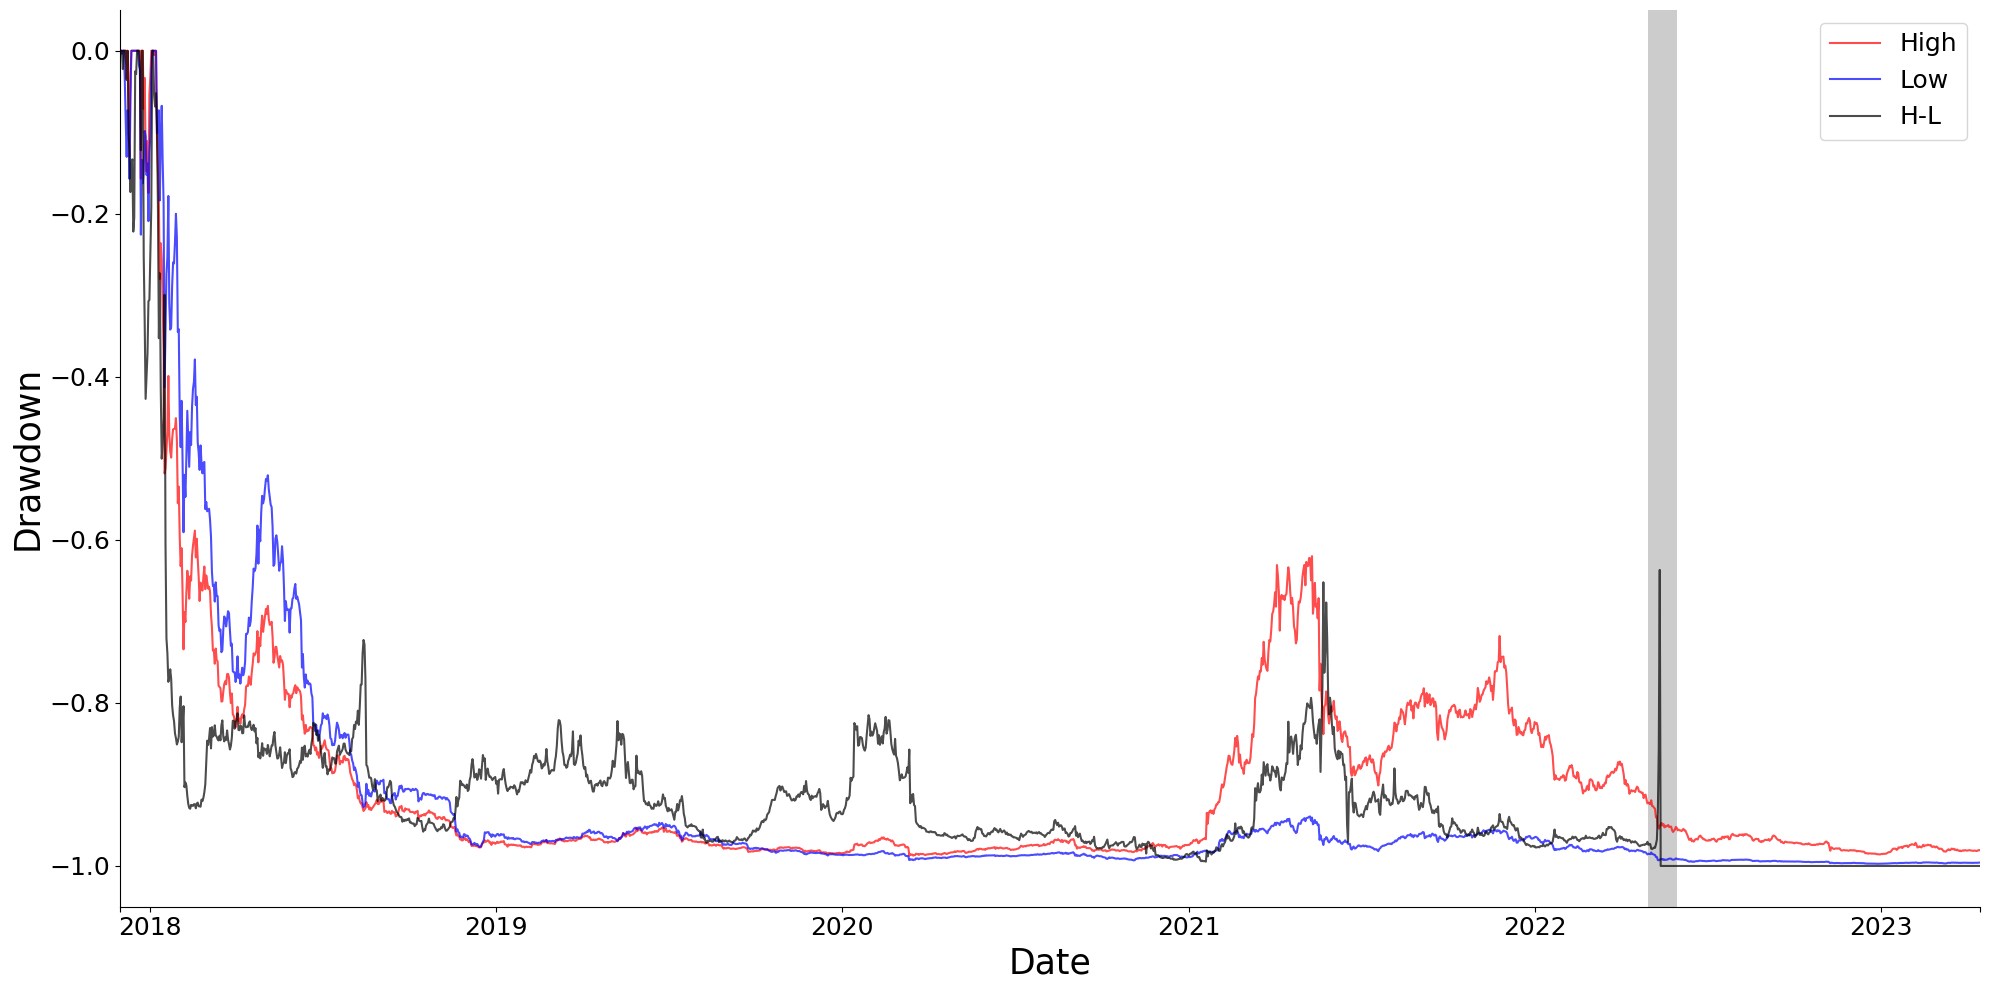

In [24]:
high = (fin_c["Long_Q5"] + 1).cumprod()
low = (fin_c["Long_Q1"] + 1).cumprod()
h_l = (fin_c["LS"] + 1).cumprod()

high_peak = high.cummax()
low_peak = low.cummax()
h_l_peak = h_l.cummax()

high_dd = (high - high_peak) / high_peak
low_dd = (low - low_peak) / low_peak
h_l_dd = (h_l - h_l_peak) / h_l_peak

pd.concat([high_dd, low_dd, h_l_dd], axis=1,
          keys=["High","Low","H-L"]).plot(figsize=(20,10), 
                                          color=["red","blue","black"],
                                          alpha=0.7,
                                          fontsize=18)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.legend(["High", "Low","H-L"], fontsize=18)

plt.minorticks_off()
plt.tight_layout();

In [25]:
mytool.print_statistics(fin_c)

,Long_Q1,Long_Q2,Long_Q3,Long_Q4,Long_Q5,LS
Mean,-0.291640,0.095990,0.326870,0.447510,0.085990,2.109400
STD,1.044515,0.970190,0.929099,0.919868,1.081028,2.457507
CAGR,-0.573400,-0.323400,-0.113200,0.006600,-0.381600,-1.000000
MDD,0.997000,0.978000,0.965000,0.953000,0.987000,1.000000
Sharpe,-0.279211,0.098939,0.351814,0.486494,0.079545,0.858350
